# Publication/Presentation figures

This notebook is used to generate pretty figures used in presentations and publications.

In [1]:
import sys
sys.path.append('../scripts/')
from utilities import *

import pandas as pd
from os.path import join
import pickle
import pdb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

sns.set()
sns.set_context('poster',font_scale=2)

idx = pd.IndexSlice

home_dir = '/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments'
s = Settings(home_dir)

int_data_dir = '../../data/int'
fig_dir = join('../../results/figures/main_experiment')
table_dir = join('../../results/tables/main_experiment')
sites = ['Nairobi','California']
txs = ['control','treatment']


colors = {'California':'#91D699',
              'Nairobi':'#F95A36',
              'treatment':'#F475EE',
              'control':'#08519C',
              'T':'#bdbdbd',
              'T_op':'#636363'}

fs = sns.plotting_context()['axes.labelsize']
fs_lab = sns.plotting_context()['legend.fontsize']*4

sns.set_context('poster',font_scale=3,rc={'font.size':32})
style = 'white'

idx = pd.IndexSlice

plot_labs = ['A','B','C','D']
mod_time_ht = {'control':5.4,
              'treatment':6.8}

out_dict = {
    't_out_dailymean':{
        'xlabel':'T (C)',
        'range':[0,30],
        'bins':np.arange(4,24,1.0)},
    'rh_out_dailymean':{
        'xlabel':'RH (%)',
        'range':[0,100],
        'bins':np.arange(0,100,5)
    }}


In [2]:
timing_df_berk = get_timing_df_berk(s)
timing_df_bus = get_timing_df_bus(s)
with open(join(int_data_dir,'sensor_data_berk.pickle'),'rb') as f:
    dfs_berk = pickle.load(f)
with open(join(int_data_dir,'sensor_data_bus.pickle'),'rb') as f:
    dfs_bus = pickle.load(f)

def interpolate_within(x):
    res = x.copy()
    if np.isnan(x[1]):
        length = x.last_valid_index()
        res[:length+1] = res[:length+1].interpolate()
    return res

/Users/ianbolliger/anaconda3/envs/cooking-people/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ianbolliger/anaconda3/envs/cooking-people/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
## Get dataframes of T timeseries by session

ts_dfs = {}

in_dfs = {'California':dfs_berk['indoor'],
         'Nairobi':dfs_bus['indoor']}
timing_dfs = {'California':timing_df_berk,
             'Nairobi':timing_df_bus}
site_settings = {'California':s.berk,
                'Nairobi':s.bus}
for site in sites:
    ts_dfs[site] = {}
    timing_df = timing_dfs[site]
    
    for grp_ix,grp in enumerate(['control','treatment']):
        grp_df = timing_df[timing_df['Treatment group']==grp_ix]
        ts_dfs[site][grp] = {}
        
        # one dataframe for each sensor location
        loc_dfs = []
        for loc in site_settings[site].sens_locs + [str(i) for i in range(1,7)] + ['Top','co2']:
            tmp_df = in_dfs[site][grp][loc].reset_index()

            # assign to session
            tmp_df['sess'] = pd.cut(tmp_df['time'],bins=grp_df.index)

            # keep only measurements during sessions
            tmp_df = tmp_df[tmp_df['sess'].notnull()]

            # get interval for each observation
            tmp_df['t_ix_sess'] = tmp_df.groupby('sess').cumcount()
            
            # adjust for when we had 5 min intervals in berkeley
            if loc in site_settings[site].sens_locs:
                tmp_df['t_ix_sess'] = tmp_df['t_ix_sess'].where(tmp_df['time'] >= s.berk.sensor_swap_date, tmp_df['t_ix_sess']*5)
            
            # pivot to wide table
            if loc=='Top':
                this_val = ['Top']
            elif loc=='co2':
                this_val = ['co2']
            else:
                this_val = ['T','RH']
            for t in this_val:
                val_by_sess = tmp_df.pivot(index='sess', columns='t_ix_sess', values=t).T
                loc_dfs.append(val_by_sess)

        # ignoring small # of sessions where only one sensor was in room
        combined_cols = set(loc_dfs[0].columns).intersection(set(loc_dfs[2].columns))
        mean_df = (loc_dfs[0].loc[:,combined_cols] + loc_dfs[2].loc[:,combined_cols])/2
        ts_dfs[site][grp]['room_avg_T'] = mean_df
        mean_df_RH = (loc_dfs[1].loc[:,combined_cols] + loc_dfs[3].loc[:,combined_cols])/2
        ts_dfs[site][grp]['room_avg_RH'] = mean_df_RH
        for i in range(1,7):
            ts_dfs[site][grp]['p{}_T'.format(i)] = loc_dfs[2*(i+1)]
            ts_dfs[site][grp]['p{}_RH'.format(i)] = loc_dfs[2*(i+1)+1]
        ts_dfs[site][grp]['T_op'] = loc_dfs[16]
        ts_dfs[site][grp]['CO2'] = loc_dfs[17]
        

In [4]:
# outdoor temps
daily_df = pd.read_stata('/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments/Analysis/participants.dta')

outs = daily_df.groupby(['nairobi','sessioncode'])['t_out_dailymean','rh_out_dailymean'].first()
outs = outs.dropna(how = 'all').astype(float).round(2)

## Outdoor histograms

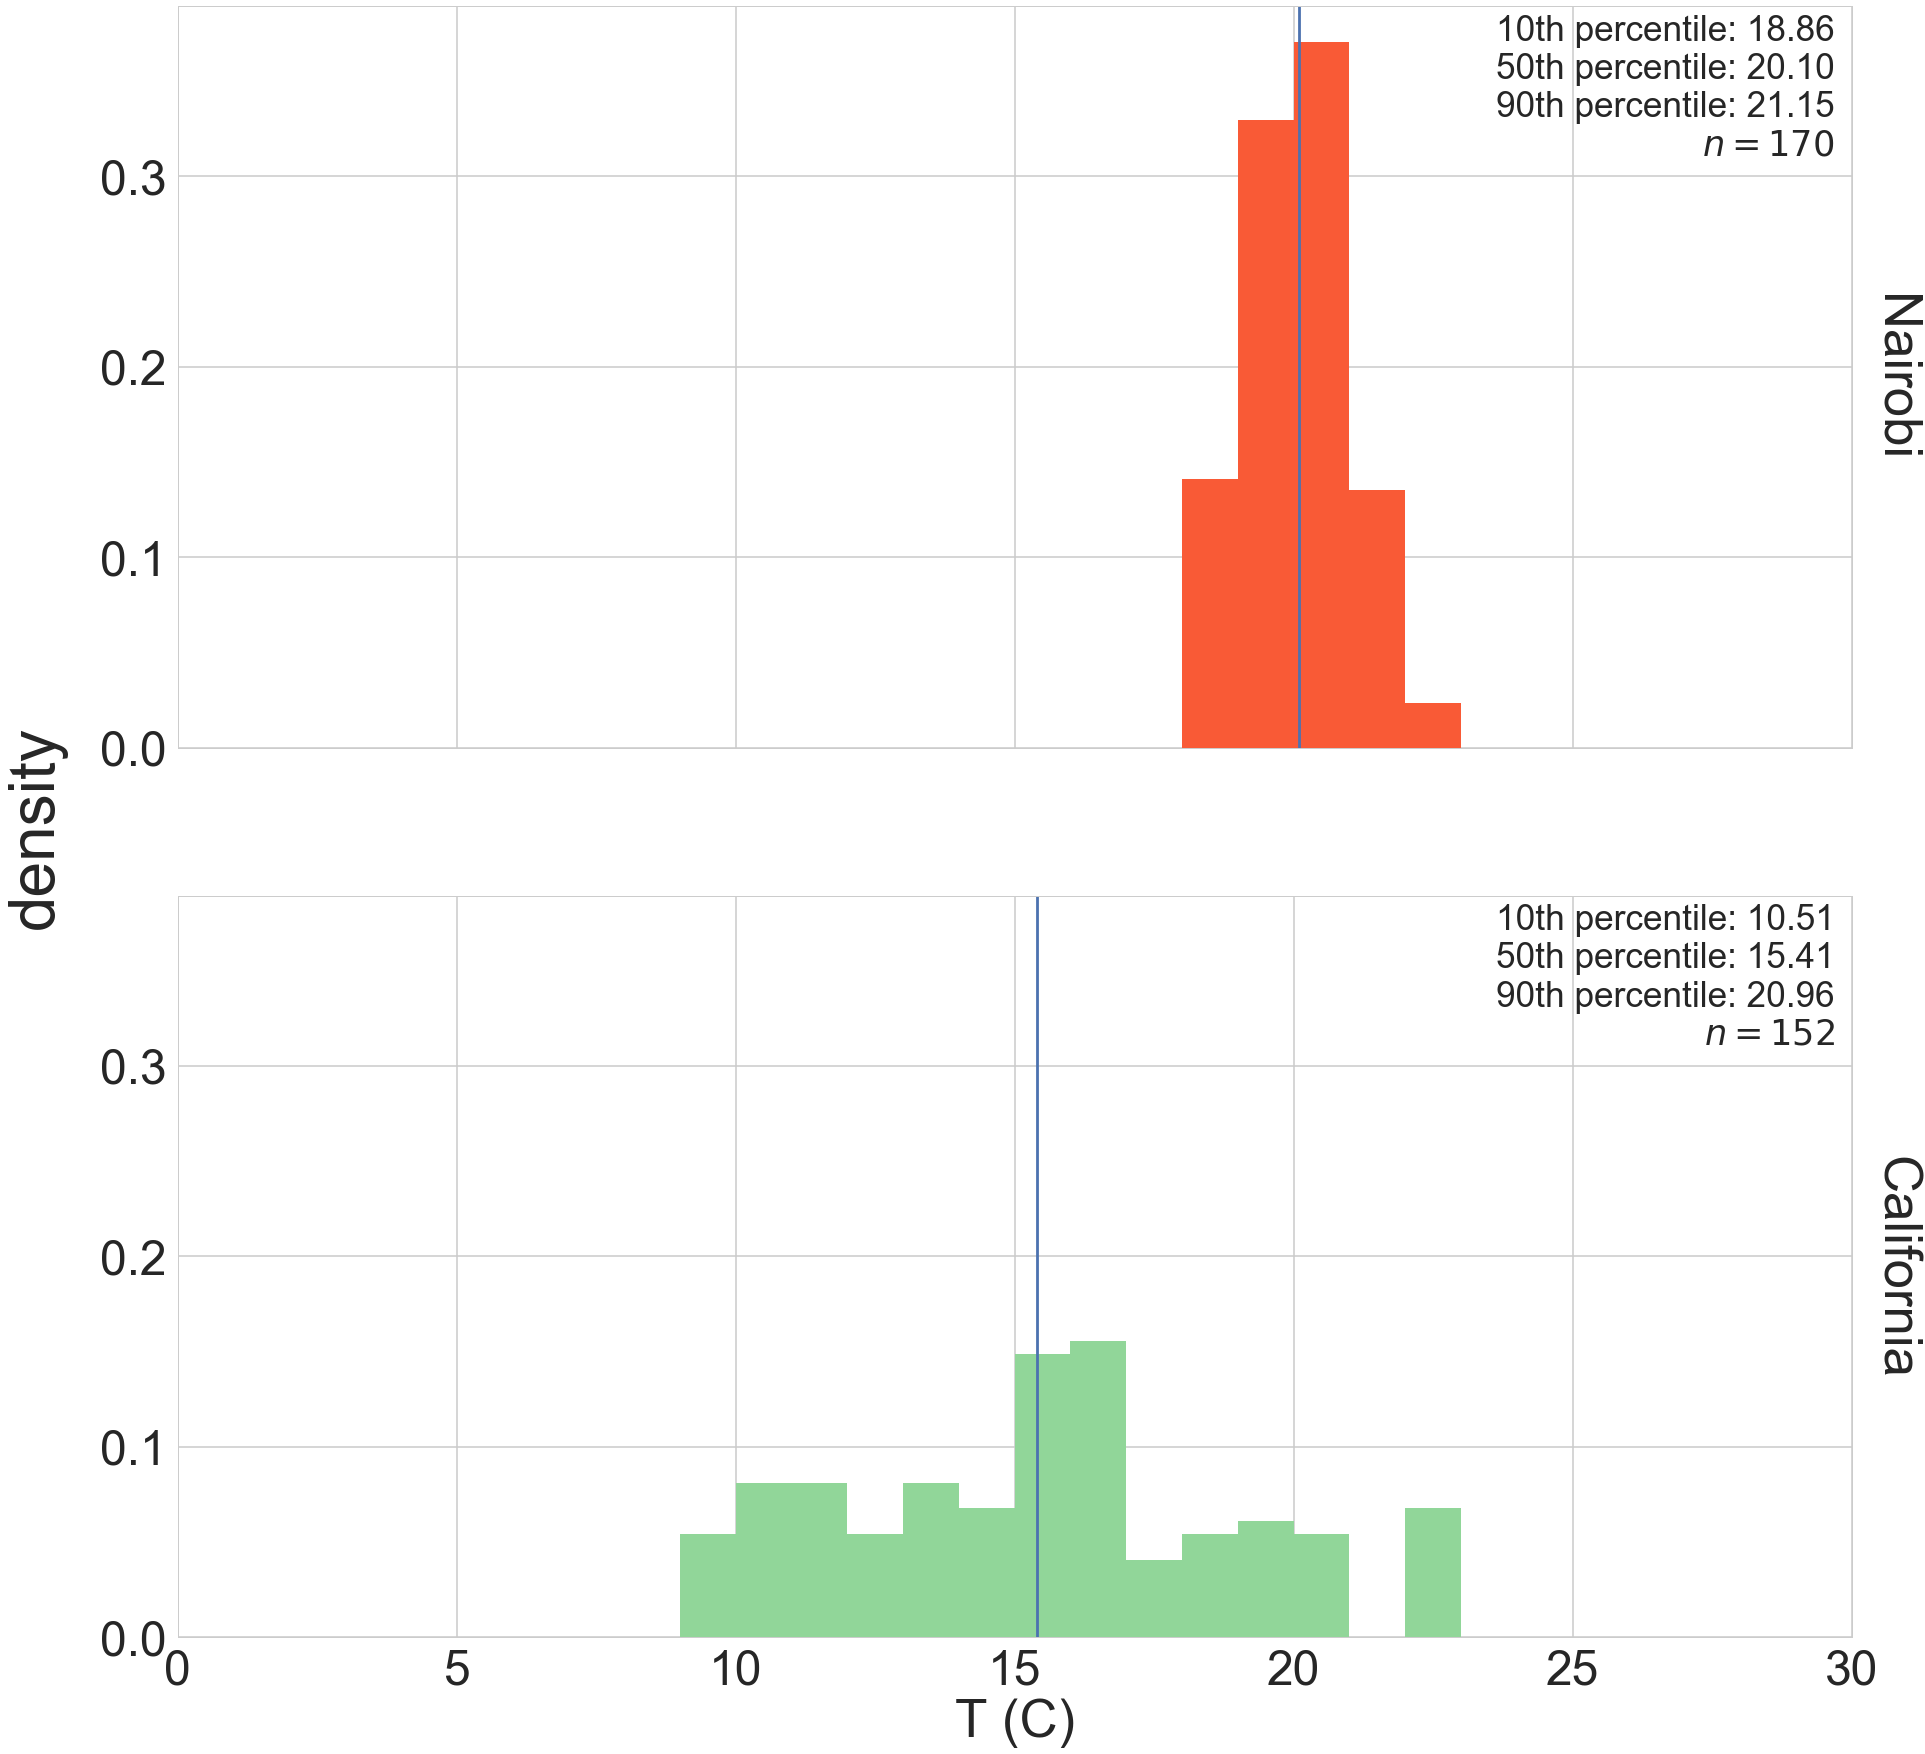

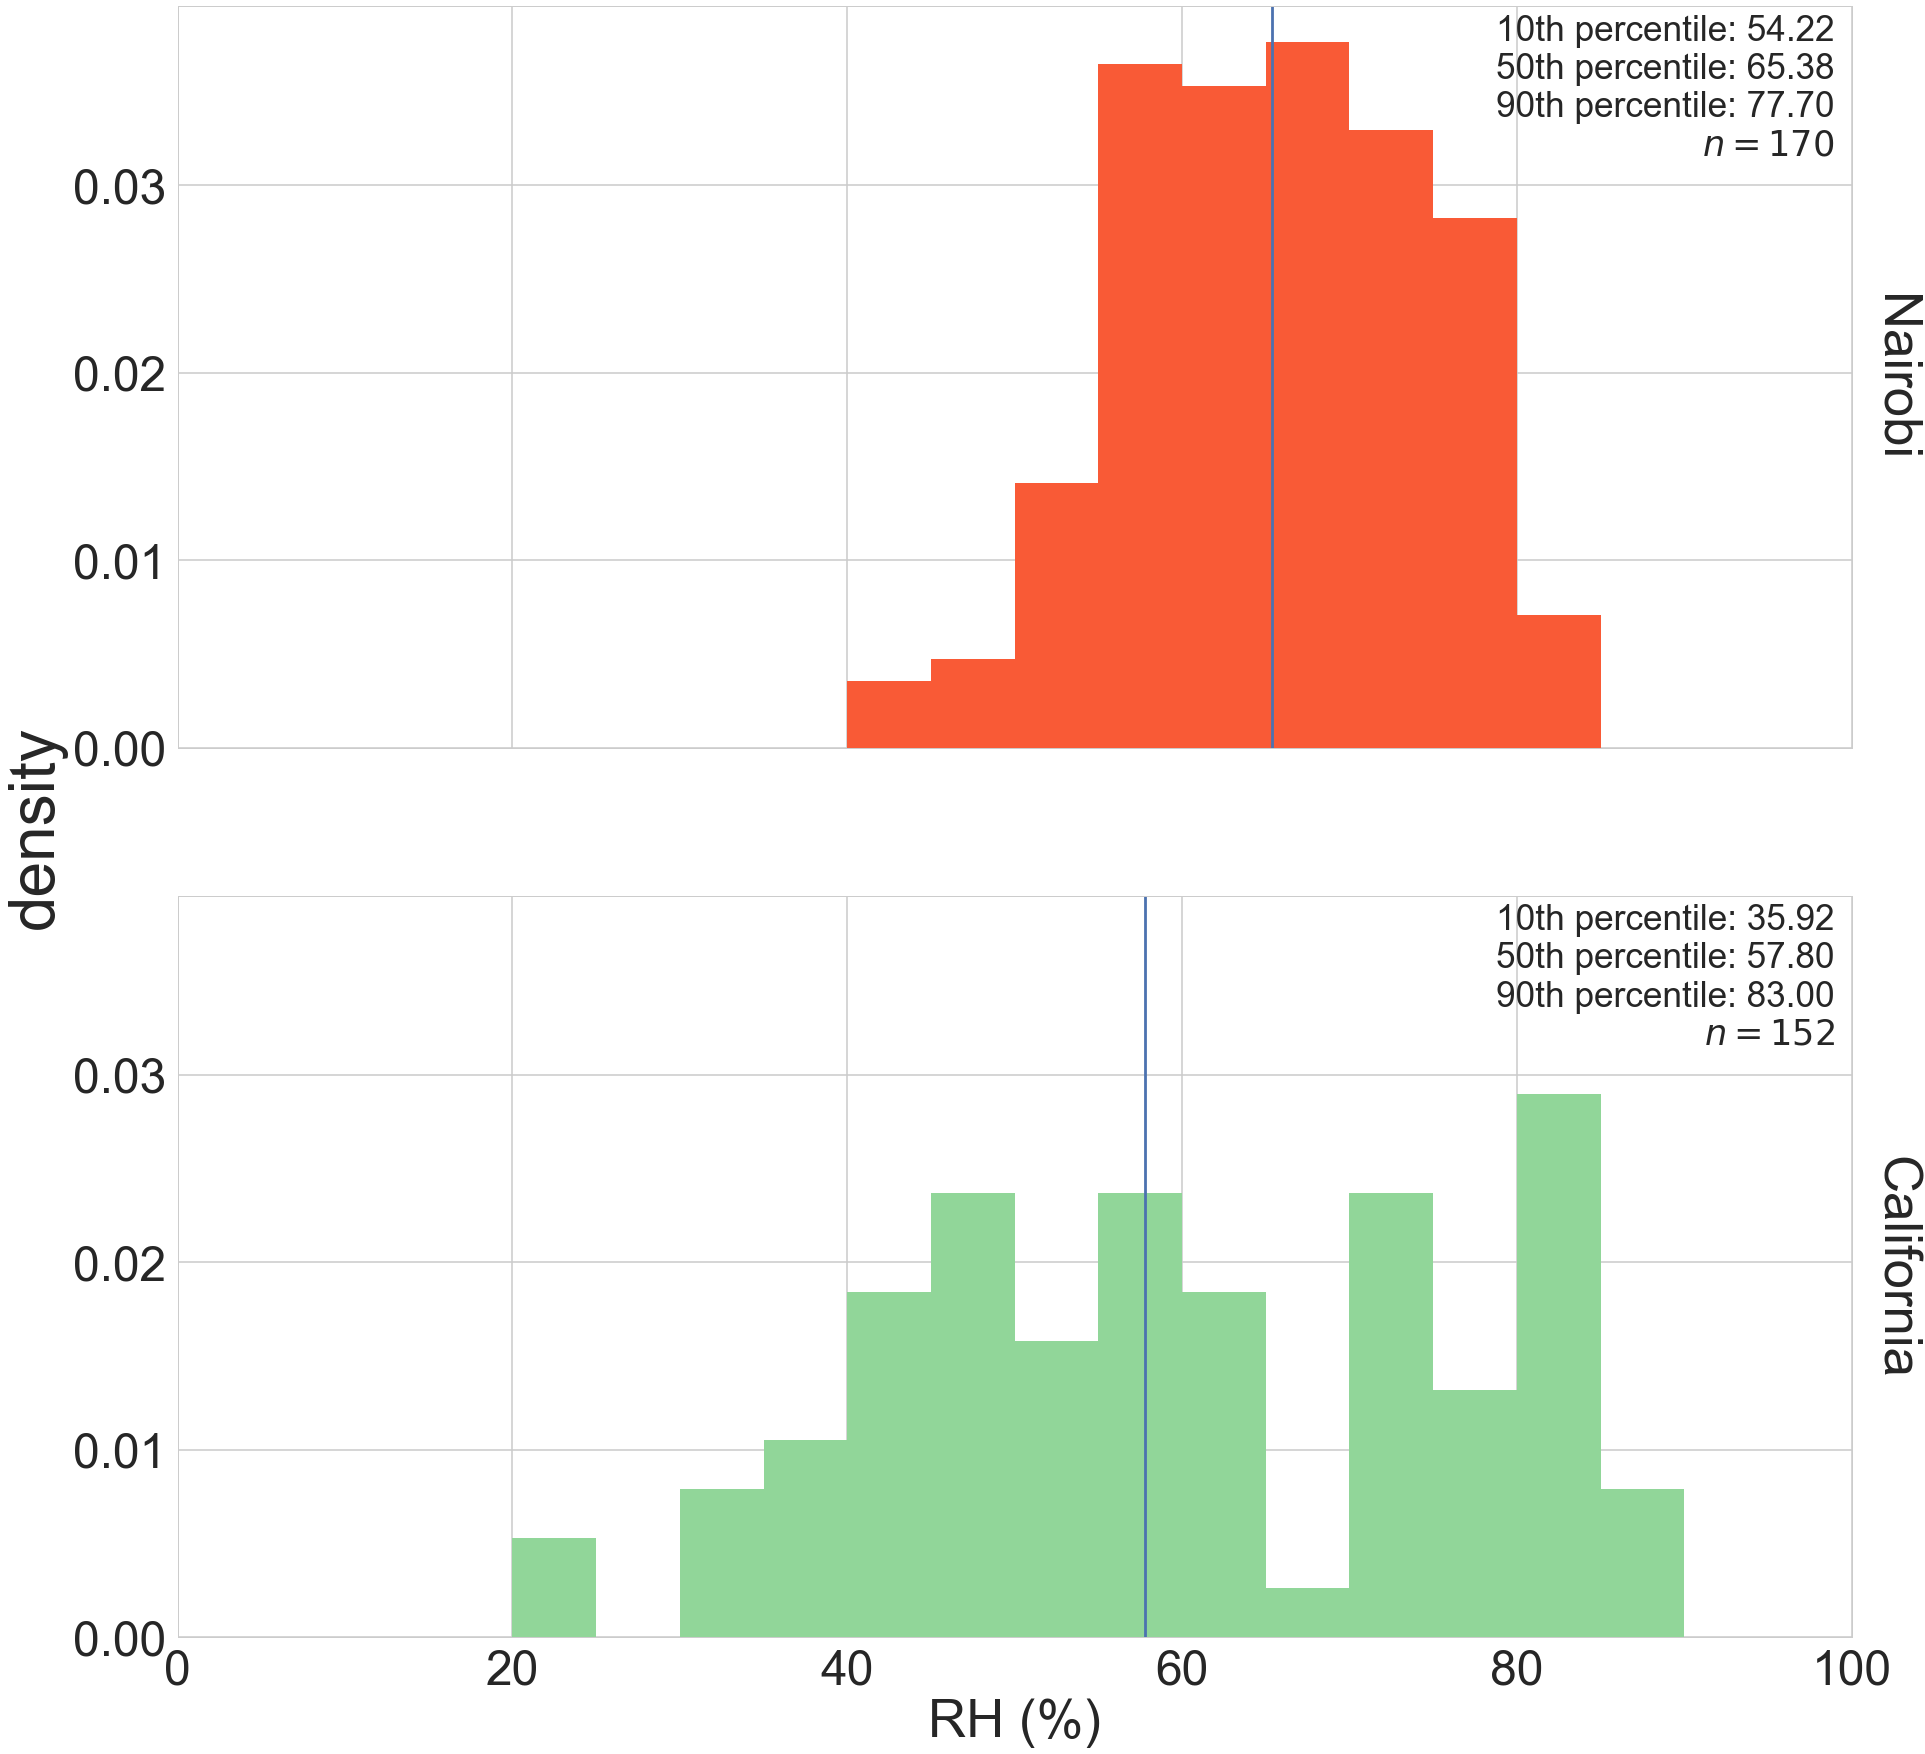

In [248]:
with sns.axes_style('whitegrid'):
    for m in ['t_out_dailymean','rh_out_dailymean']:
        
        fig, axs = plt.subplots(2,1,figsize=(30,30),sharex=True, sharey=True)
        for ix,loc in enumerate(sites):
            ax = axs[ix]
            this_df = outs[m].loc[idx[loc,:]]
            this_df.hist(ax=ax,
                        color=colors[loc],
                        bins=out_dict[m]['bins'],
                        density=True)
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(loc,rotation=270)
            ax.yaxis.set_label_coords(1.04,.5)
            ax.set_xlim(out_dict[m]['range'])
            
            n = outs.loc[idx[loc,:],:].shape[0]
            
            p50 = this_df.median()
            p10 = this_df.quantile(.1)
            p90 = this_df.quantile(.9)
            
            ax.axvline(p50)
            ax.text(.99,.99,'10th percentile: {:.2f}\n50th percentile: {:.2f}'.format(p10,p50) + 
                '\n90th percentile: {:.2f}\n$n={}$'.format(p90,n),
                ha='right',va='top', transform = ax.transAxes, fontsize=fs)
            
        fig.text(0.06, 0.5, 'density', ha='center', va='center', rotation='vertical', fontsize=fs_lab/2)
        ax.set_xlabel(out_dict[m]['xlabel'])
        
        fig.savefig('../../results/figures/main_experiment/outdoor_hist_{}.png'.format(m.split('_')[0]))


## Module Timing Table

In [5]:
from glob import glob
from os.path import basename
from datetime import timedelta

In [6]:
modules = ['production','dictator','risk_game','t_preference','trust','public_goods',
          'ravens','joy_O_D','survey','charity']
loc_dirs = {'California':join(home_dir,'Xlab data','Main experiment data','Modules'),
           'Nairobi':join(home_dir,'Busara data','Main experiment data','Modules')}

tzs = {'California':'US/Pacific',
      'Nairobi':'Africa/Nairobi'}

def ts_parser(d, tz):
    return pd.to_datetime(d, unit='s').tz_localize('UTC').tz_convert(tz).tz_localize(None)

def get_mean_temp(row,temps_df,st_time,loc,tx):
    st = int((row['start_time'] - st_time).total_seconds() / 60)
    end = int((row['end_time'] - st_time).total_seconds() / 60)
    
    if st < 0:
        ## There are many cases in Nairobi where the start time for production
        ## module occurs before the recorded starting time in the experiment_timing.csv
        ## file. IB is investigating this w/ Ray but the hunch is that the Busara team
        ## opened the experiment to the introduction page prior to participants entering room.
        ## This is b/c the time spent on the intro page is often very long. So we are assuming
        ## the start times are 0 for these cases.
#         print('For session {},{},{}: Recorded start time occurred {} min after module interaction. Dropping...'.format(
#             loc,tx,st_time,-st))
        st = 0
    return pd.Series([temps_df[st:end].mean(),st,end], index = ['temps','st','end'])


module_temps = {'California':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)},
               'Nairobi':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)}}
start_times = {'California':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)},
               'Nairobi':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)}}
end_times = {'California':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)},
               'Nairobi':{'control':pd.DataFrame(index=modules),
                              'treatment':pd.DataFrame(index=modules)}}


for loc in sites:
    date_dirs = glob(join(loc_dirs[loc],'*'))
    for d in date_dirs:
        sessions = glob(join(d,'*'))
        for s in sessions:
            sess = basename(s).split()
            if sess[2] == 'C':
                tx = 'control'
            elif sess[2] == 'T':
                tx = 'treatment'
            else:
                raise ValueError

            ts_fpath = glob(join(s,'TimeSpent*'))
            if len(ts_fpath):
                ts_fpath = ts_fpath[0]
            else:
                print('No module time data: {}'.format(s))
                continue
            this_df = pd.read_csv(ts_fpath,parse_dates = ['time_stamp'],
                                 date_parser = lambda x: ts_parser(x,tzs[loc]))
            this_df = this_df.loc[this_df['app_name'].isin(modules),['app_name','participant__id_in_session','time_stamp',
                                              'seconds_on_page']]
            this_df = this_df.sort_values(['participant__id_in_session','app_name'])
            midtime = this_df.sort_values('time_stamp').iloc[int(this_df.shape[0]/2),2]
            groups = this_df.groupby(['participant__id_in_session','app_name'])
            
            # start times
            st = groups.first()
            # For production, take starting point as "end of intro slide"
            # b/c this comes first and in busara they navigated to this page
            # before the participants entered
            page_start = st['time_stamp'] - st['seconds_on_page'].apply(
                        lambda x: timedelta(seconds=x))
            st = page_start.where(st.index.get_level_values(1) != 'production',
                          st['time_stamp'])
#             st = st['time_stamp'] - st['seconds_on_page'].apply(lambda x: timedelta(seconds=x))
            st.name = 'start_time'
            
            # end times
            end = groups.last()['time_stamp']
            end.name = 'end_time'

            # get times for temp data
            try:
                this_temps = ts_dfs[loc][tx]['room_avg_T'][midtime].interpolate()
                sess_st_time = this_temps.name.left
            except:
                continue
            
            this_times = pd.DataFrame([st,end]).T
            vals = this_times.apply(lambda x: get_mean_temp(x,this_temps,sess_st_time,loc,tx),axis=1)
            vals = vals[vals['temps'].notnull()]

            # average accross participants
            vals = vals.groupby(level=1).median()
            module_temps[loc][tx][this_temps.name] = vals['temps']
            start_times[loc][tx][this_temps.name] = vals['st']
            end_times[loc][tx][this_temps.name] = vals['end']

No module time data: /Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments/Xlab data/Main experiment data/Modules/9-25/Session 2 T


In [7]:
idx = pd.IndexSlice
ix = pd.MultiIndex.from_product([sites,txs,modules],
                               names=['location','group','module'])
t_mod_df = pd.DataFrame(index=ix,columns = ['st_time','end_time','mean_temp'])
for loc in sites:
    for tx in txs:
        this_df = pd.DataFrame({'st_time':start_times[loc][tx].median(axis=1),
                                               'end_time':end_times[loc][tx].median(axis=1),
                                               'mean_temp':module_temps[loc][tx].median(axis=1)})
        this_df.index = pd.MultiIndex.from_product([[loc],
                                                    [tx],list(start_times[loc][tx].index)],
                                                   names=['location','group','module'])
        t_mod_df.loc[idx[loc,tx,:],:] = this_df

/Users/ianbolliger/anaconda3/envs/cooking-people/lib/python3.7/site-packages/ipykernel/ipkernel.py:294: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [13]:
t_mod_df.to_csv('/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments/Analysis/Tables/module_level_temps.csv')

## Plots

In [9]:
module_labs = {
    'production': 'a',
    'ravens': 'b',
    'survey': 'c',
    'risk_game': 'd',
    't_preference': 'e',
    'dictator': 'f',
    'trust': 'g',
    'public_goods': 'h',
    'joy_O_D': 'i',
    'charity': 'j'
}

### Temperature Watercolors

Nairobi Control mean = 21.7
Nairobi control SD: 0.13786588258717364
N=79
Nairobi Treatment mean = 31.3
Nairobi treatment SD: 0.32698844272676875
N=77
California Control mean = 21.8
California control SD: 0.16802428344989068
N=76
California Treatment mean = 30.2
California treatment SD: 0.17976669889820587
N=76


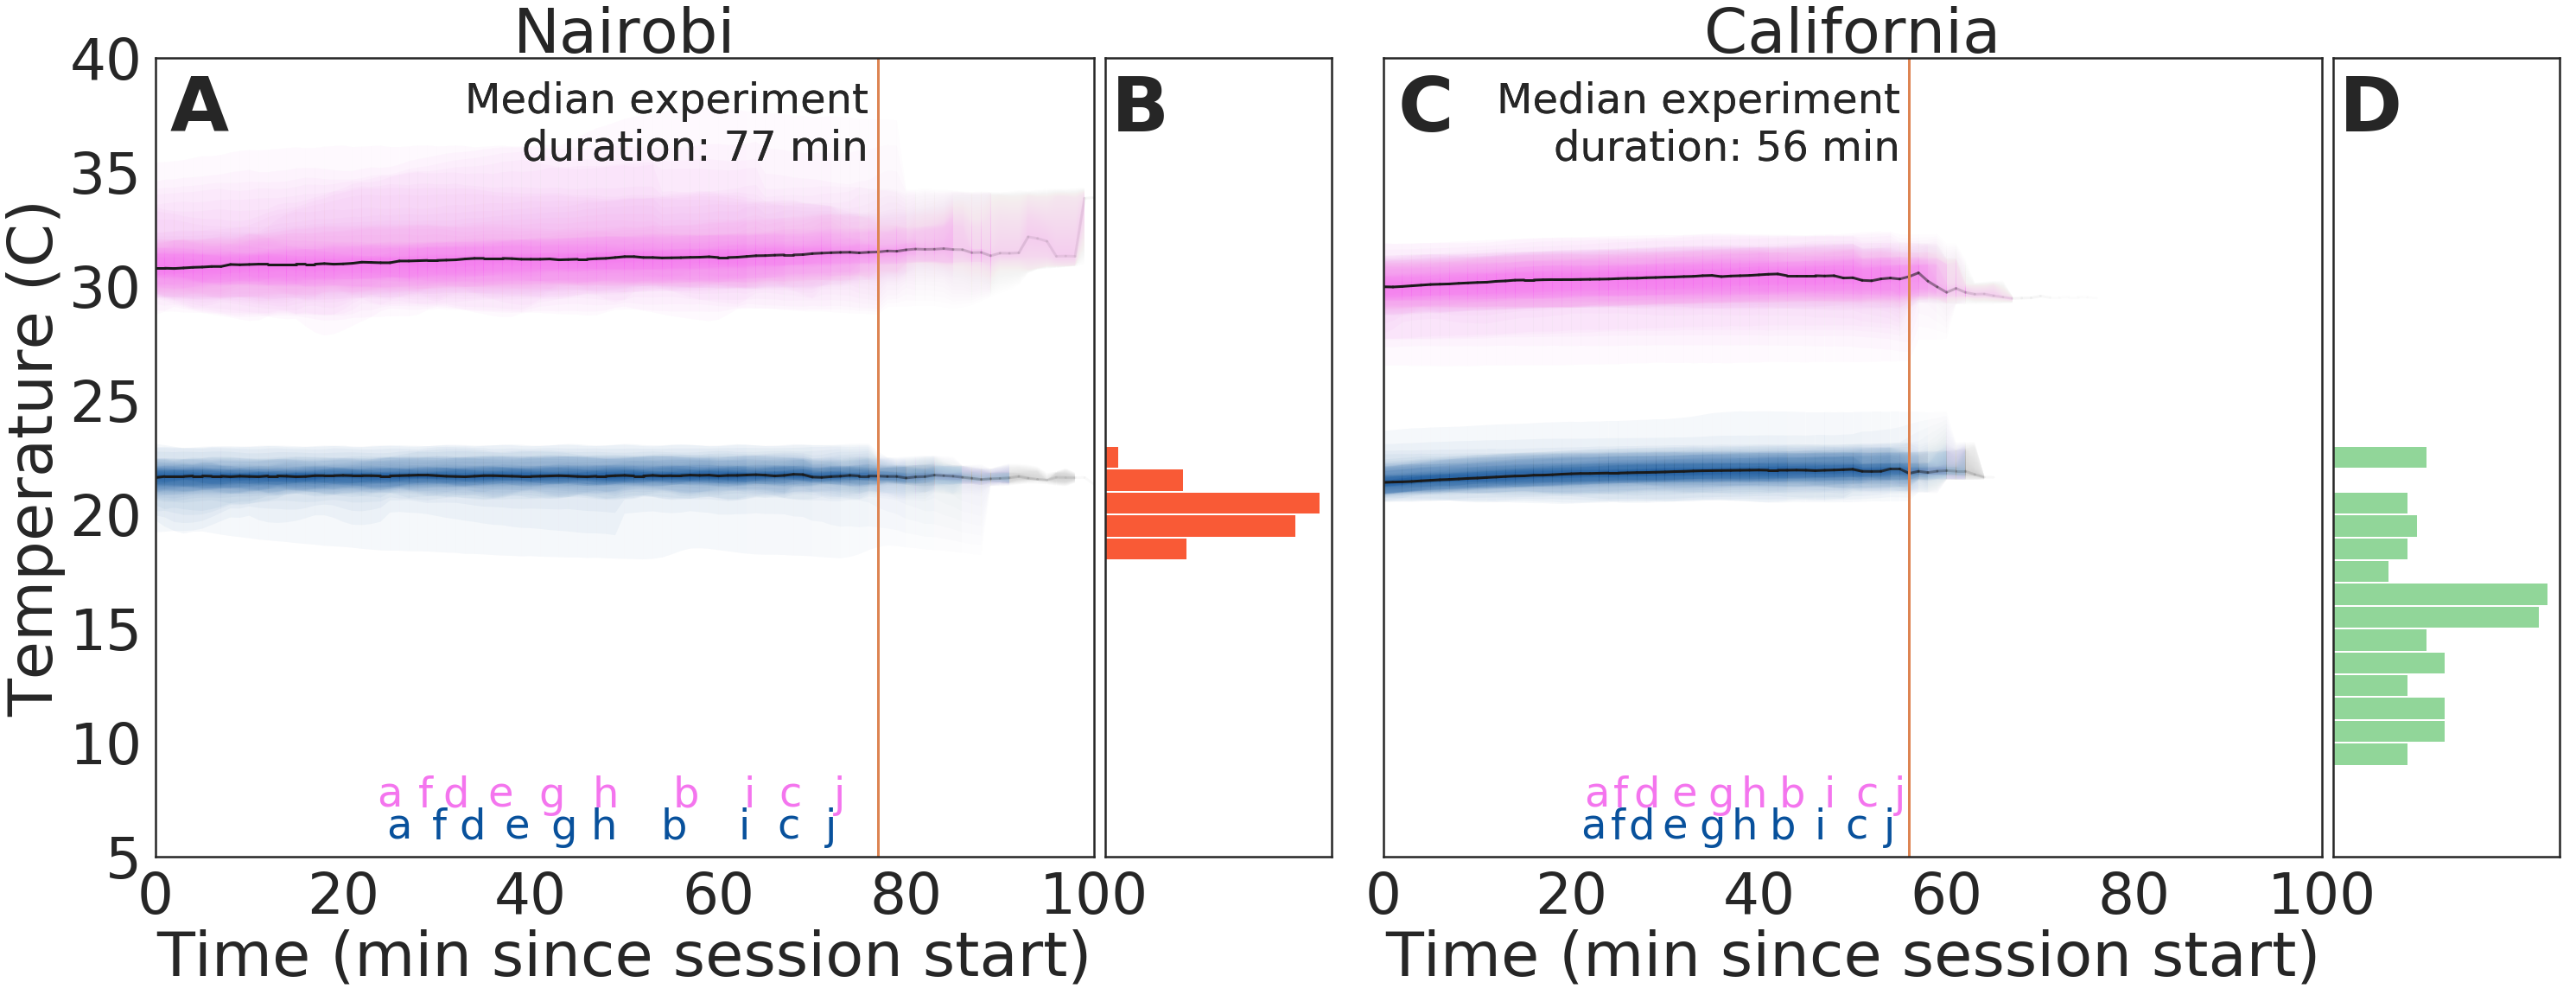

In [18]:
from matplotlib.ticker import NullFormatter
from matplotlib import gridspec

nullfmt = NullFormatter()


with sns.axes_style(style):
    fig = plt.figure(figsize=(42,17))
    axs = []
    gs1 = gridspec.GridSpec(1,5)
    gs1.update(left=0.06, right=0.51, wspace=0.05)
    axs.append(plt.subplot(gs1[:, :-1]))
    axs.append(plt.subplot(gs1[:, -1]))

    gs2 = gridspec.GridSpec(1,5)
    gs2.update(left=0.53, right=0.98, wspace=0.05)
    axs.append(plt.subplot(gs2[:, :-1]))
    axs.append(plt.subplot(gs2[:, -1]))

    axs[0].set_ylabel('Temperature (C)')
    for six,site in enumerate(sites):
        lines = []
        ax = axs[six*2]
        ax.set_title(site)
        ax_hist = axs[six*2+1]
        
        outs['t_out_dailymean'].loc[idx[site,:]].hist(orientation='horizontal',bins=out_dict['t_out_dailymean']['bins'],
                    color=colors[site],ax = ax_hist)
        ax_hist.grid(False)
        ax_hist.set_ylim((5,40))
        ax_hist.yaxis.set_major_formatter(nullfmt)
        ax_hist.xaxis.set_major_formatter(nullfmt)
        
        for grpix,grp in enumerate(txs):
            if grp == 'treatment':
                lab_ht = 29.9
            else:
                lab_ht = 20.7
            this_df = ts_dfs[site][grp]['room_avg_T'].copy()
            length = this_df.apply(lambda x: x.last_valid_index())
            this_df = this_df.apply(interpolate_within)
            
            sd = this_df.std()
            mean_of_sd = sd.mean()
            mean_of_mean = this_df.mean().mean()
            med = this_df.quantile(q=.5,axis=1)
            count = this_df.count(axis=1)
            mean_of_med = (med*count).sum()/count.sum()
            med_length = length.median()
            n = this_df.shape[1]
            
            txt = '{} mean = {:.1f}'.format(
                    grp.title(),mean_of_mean)
#             ax.text(med_length-1,lab_ht+1.5, txt, verticalalignment='bottom',
#                   horizontalalignment='right')
            print('{} {}\n{} {} SD: {}\nN={}'.format(site,txt, site, grp, mean_of_sd, n))
            
            for j in range(count.index.shape[0]-1):
                line, = ax.plot(med.index[j:j+2],med[j:j+2], color = 'k', 
                    label = txt, alpha = count[j]/count.max())
                if j == count.index.shape[0]-2:
                    lines.append(line)
            ax.plot([med_length,med_length],[0, 40])
            ax.text(med_length-1,39,'Median experiment\nduration: {:d} min'.format(int(med_length)),
                    verticalalignment='top',horizontalalignment='right',fontsize=fs)
            for i in np.arange(0,.5,.01):
                this_quantile_low = this_df.quantile(q=i,axis=1)
                this_quantile_high = this_df.quantile(q=1-i,axis=1)
                for j in range(count.index.shape[0]-1):
                    poly = ax.fill_between([this_quantile_low.index[j],this_quantile_low.index[j+1]],
                                           this_quantile_low.iloc[j:j+2], this_quantile_high.iloc[j:j+2],
                                           alpha=.0005*count.iloc[j],color = colors[grp])
                    poly.set_edgecolor('none')

            # add in time of module labels
            this_df_mod = t_mod_df.loc[idx[site,grp,:],:]
            for m in module_labs.keys():
                time = (this_df_mod.loc[idx[site,grp,m],'end_time'] + this_df_mod.loc[idx[site,grp,m],'st_time'])/2
                ax.text(time,mod_time_ht[grp],module_labs[m], ha='center', va = 'bottom', color = colors[grp],
                        fontsize=fs)
                
        
        ax.text(.015,.98,plot_labs[six*2],va='top',transform=ax.transAxes, fontweight='bold', fontsize=fs_lab/2)
        ax_hist.text(.025,.98,plot_labs[six*2+1],va='top',transform=ax_hist.transAxes, fontweight='bold', fontsize=fs_lab/2)
        ax.set_xlabel('Time (min since session start)')
        ax.set_ylim((5,40))
            
    axs[0].set_xlim((0,100))
    axs[2].set_xlim((0,100))
    axs[2].yaxis.set_major_formatter(nullfmt)

# fig.savefig(join(fig_dir,'watercolor_temps_{}_squished.pdf'.format(style)))

### Boxplots

#### T_op

In [117]:
Top_box_df = pd.DataFrame(columns=['T','T_type','Group','Site'])
for site in sites:
    dfs = {'T_op':{},
          'T':{}}
    timing = timing_dfs[site].loc[:,['Date','Session in day','Treatment group']]
    for i,tx in enumerate(txs):
        dfs['T_op'][tx] = ts_dfs[site][tx]['T_op'].T
        dfs['T'][tx] = ts_dfs[site][tx]['room_avg_T'].T
        dfs['T'][tx] = dfs['T'][tx].reindex(dfs['T_op'][tx].index)

        # take only 5 minute measurements to match T_op
        dfs['T_op'][tx].columns = dfs['T_op'][tx].columns * 5
        dfs['T'][tx] = dfs['T'][tx].loc[:,dfs['T_op'][tx].columns]
        dfs['T'][tx] = dfs['T'][tx].loc[:,~dfs['T'][tx].isnull().all(axis=0)]
        
        # make sure we get same measurements from each session-condition
        # for both T and T_op
        dfs['T'][tx] = dfs['T'][tx].where((dfs['T'][tx].notnull()) & (dfs['T_op'][tx].notnull()),
                                          np.nan)
        dfs['T_op'][tx] = dfs['T_op'][tx].where((dfs['T'][tx].notnull()) & (dfs['T_op'][tx].notnull()),
                                          np.nan)
        
    
        dfs['T'][tx] = dfs['T'][tx].join(timing.loc[timing['Treatment group']==i])
        del dfs['T'][tx]['Treatment group']
        dfs['T'][tx].set_index(['Date','Session in day'], drop=True, inplace=True)
        dfs['T_op'][tx] = dfs['T_op'][tx].join(timing.loc[timing['Treatment group']==i])
        del dfs['T_op'][tx]['Treatment group']
        dfs['T_op'][tx].set_index(['Date','Session in day'], drop=True, inplace=True)
        
    dfs['T_op']['diff'] = dfs['T_op']['treatment'] - dfs['T_op']['control']
    dfs['T_op']['diff'].dropna(how='all',inplace=True)
    dfs['T']['diff'] = dfs['T']['treatment'] - dfs['T']['control']
    dfs['T']['diff'].dropna(how='all',inplace=True)
    
    for t_type in ['T','T_op']:
        for tx in ['control','treatment','diff']:
            dfs[t_type][tx] = pd.DataFrame({'T':np.array(dfs[t_type][tx]).flatten()})
            dfs[t_type][tx] = dfs[t_type][tx][dfs[t_type][tx].notnull()['T']]
            dfs[t_type][tx]['Group'] = tx
            dfs[t_type][tx]['Site'] = site
            dfs[t_type][tx]['T_type'] = t_type
            dfs[t_type][tx].reset_index(drop=True, inplace=True)
            Top_box_df = Top_box_df.append(dfs[t_type][tx])
            
Top_box_df.reset_index(drop=True,inplace=True)
Top_box_df.rename(columns={'T':'Temp (C)',
                          'T_type':'Measurement'}, inplace=True)
Top_box_df['Group'] = Top_box_df['Group'].str.title()
def label_func(x):
    if x == 'Control':
        return 'A) Control'
    elif x == 'Treatment':
        return 'B) Treatment'
    elif x == 'Diff':
        return 'C) Diff'
Top_box_df['Group'] = Top_box_df['Group'].apply(label_func)

/Users/ianbolliger/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


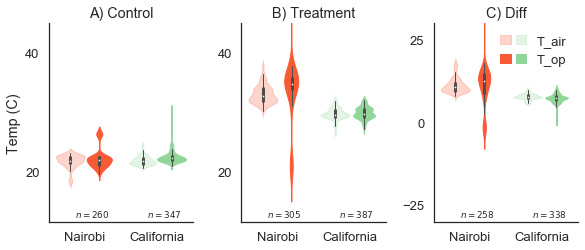

In [246]:
from matplotlib.legend_handler import HandlerTuple
kind='violin'
tup_handl = HandlerTuple(ndivide=None)
ns = Top_box_df.groupby(['Group','Site','Measurement']).count()
panels = ['A) Control','B) Treatment','C) Diff']
with sns.plotting_context('talk',rc={'lines.linewidth':1}):
    with sns.axes_style(style):
        g = sns.factorplot(x="Site", y="Temp (C)", hue="Measurement", col='Group',
                        data=Top_box_df, kind=kind, size=4, aspect=.7,
                      sharey=False, hue_order= ['T','T_op'],color='grey',legend=False)
        g.set_axis_labels("",'Temp (C)').set_titles("{col_name}")
        
        ax = g.axes
        lb = min(ax[0,0].get_ylim()[0],ax[0,1].get_ylim()[0])
        ub = 45
        ax[0,0].set_ylim((lb,ub))
        ax[0,1].set_ylim((lb,ub))
        ax[0,2].set_ylim((-30,30))
        for aix,a in enumerate(ax.flatten()):
            [a.collections[i].set_color(colors['Nairobi']) for i in [0,2]]
            [a.collections[i].set_color(colors['California']) for i in [4,6]]
            [a.collections[i].set_alpha(.25) for i in [0,4]]
            n_N = ns.loc[idx[panels[aix],'Nairobi','T'],'Temp (C)']
            n_C = ns.loc[idx[panels[aix],'California','T'],'Temp (C)']
            a.text(.18,.02,'$n={}$                $n={}$'.format(n_N,n_C),
                   transform=a.transAxes,fontsize=fs/4)
            
        handles = [(a.collections[0],a.collections[4]),(a.collections[2],a.collections[6])]
        lab = ['T_air','T_op']
        a.legend(handles,lab,handler_map={tuple:tup_handl})
plt.savefig(join(fig_dir,'{}_Top.png'.format(kind)))

### RH

In [125]:
box_dfs = {}
RH_box_df = pd.DataFrame(columns=['RH','Group','Site'])
for site in sites:
    timing = timing_dfs[site].loc[:,['Date','Session in day','Treatment group']]
    for i,tx in enumerate(txs):
        box_dfs[tx] = ts_dfs[site][tx]['room_avg_RH'].T
    
        box_dfs[tx] = box_dfs[tx].join(timing.loc[timing['Treatment group']==i])
        del box_dfs[tx]['Treatment group']
        box_dfs[tx].set_index(['Date','Session in day'], drop=True, inplace=True)
        
    box_dfs['diff'] = box_dfs['treatment'] - box_dfs['control']
    box_dfs['diff'].dropna(how='all',inplace=True)
    
    for tx in ['control','treatment','diff']:
        box_dfs[tx] = pd.DataFrame({'RH':np.array(box_dfs[tx]).flatten()})
        box_dfs[tx] = box_dfs[tx][box_dfs[tx].notnull()['RH']]
        box_dfs[tx]['Group'] = tx
        box_dfs[tx]['Site'] = site
        box_dfs[tx].reset_index(drop=True, inplace=True)
        RH_box_df = RH_box_df.append(box_dfs[tx])
        
            
RH_box_df.reset_index(drop=True,inplace=True)
RH_box_df.rename(columns={'RH':'Relative Humidity (%)'}, inplace=True)
RH_box_df['Group'] = RH_box_df['Group'].str.title()
def label_func(x):
    if x == 'Control':
        return 'A) Control'
    elif x == 'Treatment':
        return 'B) Treatment'
    elif x == 'Diff':
        return 'C) Diff'
RH_box_df['Group'] = RH_box_df['Group'].apply(label_func)

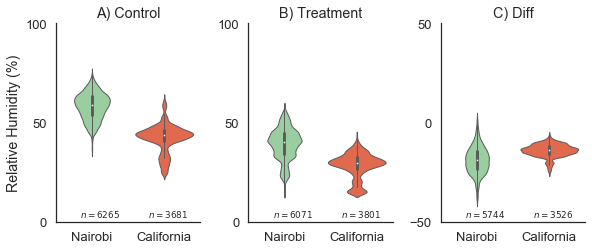

In [245]:
kind='violin'
ns_RH = RH_box_df.groupby(['Group','Site']).count()
with sns.plotting_context('talk',rc={'lines.linewidth':1}):
    with sns.axes_style(style):
        g = sns.factorplot(x="Site", y='Relative Humidity (%)', col='Group',
                        data=RH_box_df, kind=kind, size=4, aspect=.7,
                      sharey=False, palette = [colors['California'],colors['Nairobi']])
        ax = g.axes
        lb = 0
        ub = 100
        ax[0,0].set_ylim((lb,ub))
        ax[0,1].set_ylim((lb,ub))
        ax[0,2].set_ylim((-50,50))
        for aix,a in enumerate(ax.flatten()):
            n_N = ns_RH.loc[idx[panels[aix],'Nairobi'],'Relative Humidity (%)']
            n_C = ns_RH.loc[idx[panels[aix],'California'],'Relative Humidity (%)']
            a.text(.17,.02,'$n={}$            $n={}$'.format(n_N,n_C),
                   transform=a.transAxes,fontsize=fs/4)
        
        g.set_axis_labels("",'Relative Humidity (%)').set_titles("{col_name}")
plt.savefig(join(fig_dir,'{}_RH.png'.format(kind)))

### CO2

In [129]:
box_dfs = {}
CO2_box_df = pd.DataFrame(columns=['CO2','Group','Site'])
for site in sites:
    timing = timing_dfs[site].loc[:,['Date','Session in day','Treatment group']]
    for i,tx in enumerate(txs):
        box_dfs[tx] = ts_dfs[site][tx]['CO2'].T
        box_dfs[tx] = box_dfs[tx].join(timing.loc[timing['Treatment group']==i])
        del box_dfs[tx]['Treatment group']
        box_dfs[tx].set_index(['Date','Session in day'], drop=True, inplace=True)
        
    box_dfs['diff'] = box_dfs['treatment'] - box_dfs['control']
    box_dfs['diff'].dropna(how='all',inplace=True)
    
    for tx in ['control','treatment','diff']:
        box_dfs[tx] = pd.DataFrame({'CO2':np.array(box_dfs[tx]).flatten()})
        box_dfs[tx] = box_dfs[tx][box_dfs[tx].notnull()['CO2']]
        box_dfs[tx]['Group'] = tx
        box_dfs[tx]['Site'] = site
        box_dfs[tx].reset_index(drop=True, inplace=True)
        CO2_box_df = CO2_box_df.append(box_dfs[tx])
            
CO2_box_df.reset_index(drop=True,inplace=True)
CO2_box_df.rename(columns={'CO2':'CO2 (ppm)'}, inplace=True)
CO2_box_df['Group'] = CO2_box_df['Group'].str.title()
def label_func(x):
    if x == 'Control':
        return 'A) Control'
    elif x == 'Treatment':
        return 'B) Treatment'
    elif x == 'Diff':
        return 'C) Diff'
CO2_box_df['Group'] = CO2_box_df['Group'].apply(label_func)

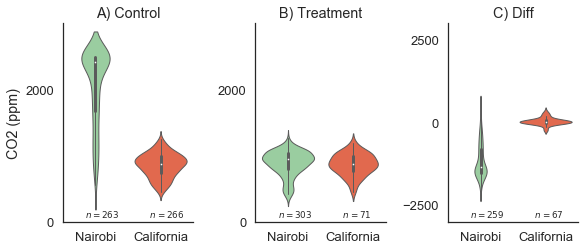

In [247]:
kind='violin'
ns_CO2 = CO2_box_df.groupby(['Group','Site']).count()
with sns.plotting_context('talk',rc={'lines.linewidth':1}):
    with sns.axes_style(style):
        g = sns.factorplot(x="Site", y='CO2 (ppm)', col='Group',
                        data=CO2_box_df, kind=kind, size=4, aspect=.7,
                      sharey=False, palette = [colors['California'],colors['Nairobi']])
        ax = g.axes
        lb = 0
        ub = 3000
        ax[0,0].set_ylim((lb,ub))
        ax[0,1].set_ylim((lb,ub))
        ax[0,2].set_ylim((-3000,3000))
        for aix,a in enumerate(ax.flatten()):
            n_N = ns_CO2.loc[idx[panels[aix],'Nairobi'],'CO2 (ppm)']
            n_C = ns_CO2.loc[idx[panels[aix],'California'],'CO2 (ppm)']
            a.text(.17,.02,'$n={}$             $n={}$'.format(n_N,n_C),
                   transform=a.transAxes,fontsize=fs/4)
            
        g.set_axis_labels("",'CO2 (ppm)').set_titles("{col_name}")
plt.savefig(join(fig_dir,'{}_CO2.png'.format(kind)))

# Summary table of other environmental vars

In [250]:
from scipy.stats import ttest_rel,ttest_ind
fpaths = {'California':join(s.berk.home_dir,'session_level_environmental_data.csv'),
         'Nairobi':join(s.bus.home_dir,'session_level_environmental_data.csv')}

def p_to_stars(pval):
    if pval < .01:
        return '**'
    elif pval < .05:
        return '*'
    else:
        return ''

In [251]:
sess_dfs = {}
for f in fpaths.keys():
    sess_dfs[f] = pd.read_csv(fpaths[f],parse_dates=['date'],
                              index_col = ['date','session','treatment'],
                             usecols=['date','session','treatment','RH_in_mean',
                                     'Top_mean','co2_mean','T_in_mean'])

In [252]:
measured_vars = ['T_op','CO2','lighting','background_noise']

results = pd.DataFrame(index = pd.MultiIndex(levels=[measured_vars,['mean','std']],
                                            labels = [[0,0,1,1,2,2,3,3],[0,1,0,1,0,1,0,1]],
                                            names = ['Variable','Metric']),
                      columns = pd.MultiIndex(levels=[sites,['Control','Heat','n','diff']],
                                             labels=[[0,0,0,0,1,1,1,1],[0,1,2,3,0,1,2,3]]),
                      dtype=np.float64)
results.loc[:,idx[:,'diff']] = results.loc[:,idx[:,'diff']].astype(str)


for loc in sites:
    this_df = sess_dfs[loc].loc[:,['Top_mean','co2_mean']].rename(
        columns={'Top_mean':'T_op','co2_mean':'CO2'}).rename(
        index={0:'Control',1:'Heat'},level=2)
    
    # take only sessions where measurements for both control and hot
    valid = this_df.groupby(level=[0,1]).count()==2
    new_df = this_df.join(valid,on=['date','session'],rsuffix='_valid')
    for i in ['T_op','CO2']:
        new_df[i] = new_df[i].where(new_df[i+'_valid'],np.nan)
    this_df = new_df[['T_op','CO2']]
    
    # get sample size
    ns = this_df.groupby(level=2).count().T['Control']
    for i in ['T_op','CO2']:
        results.loc[idx[i,'mean'],idx[loc,'n']] = ns[i]
    
    for metric in ['mean','std']:
        vals = this_df.groupby(level=2).agg(metric).T
        vals.index = pd.MultiIndex.from_product([vals.index,[metric]])
        vals.columns = pd.MultiIndex.from_product([[loc],['Control','Heat']])
        vals.index.names = ['Variable','Metric']
        results.loc[vals.index,vals.columns] = vals
        
    # get p-val
    for var in ['T_op','CO2']:
        ctrl = this_df.loc[idx[:,:,'Control'],var].reset_index(level=2,drop=True)
        tx = this_df.loc[idx[:,:,'Heat'],var].reset_index(level=2,drop=True)
        
        # correct for when measured in one room not other
        diff = pd.Index(set(ctrl.index).intersection(set(tx.index)),names=['date','session'])
        ctrl = ctrl.reindex(diff)
        tx = tx.reindex(diff)
        
        pval = ttest_rel(ctrl,tx,nan_policy='omit').pvalue
        results.loc[idx[var,'mean'],idx[loc,'diff']] = p_to_stars(pval)
        
results.loc[idx[:,'std'],idx[:,'diff']] = ''

#### incorporate measured-once metrics

In [253]:
metrics_dirs = {'California':join(s.berk.home_dir,'Other Environmental Vars'),
         'Nairobi':join(s.bus.home_dir,'Other Environmental Vars')}

##### Berkeley

In [254]:
# lighting

lighting_df = pd.read_csv(join(metrics_dirs['California'],'lighting_lux.csv'), index_col=0, nrows=6, usecols = ['Participant No.','Control Avg','Treatment Avg'])
lighting_df.rename(columns = {'Control Avg':'Control', 'Treatment Avg':'Heat'},inplace=True)

vals = {}
for m in ['mean','std']:
    vals = lighting_df.agg(m)
    vals.index = pd.MultiIndex.from_product([['California'],vals.index])

    results.loc[idx['lighting',m],idx['California',['Control','Heat']]] = vals
    
pval = ttest_ind(lighting_df['Control'],lighting_df['Heat']).pvalue
results.loc[idx['lighting','mean'],idx['California','diff']] = p_to_stars(pval)

# noise
noise_df = pd.read_csv(join(metrics_dirs['California'],'sound_dba.csv'))
results.loc[idx['background_noise','mean'],idx['California','Control']] = noise_df.loc[0,'control']
results.loc[idx['background_noise','mean'],idx['California','Heat']] = noise_df.loc[0,'treatment']

##### Nairobi

In [255]:
enviro_df = pd.read_csv(join(metrics_dirs['Nairobi'],'Light & Sound Data.csv'), index_col=0, nrows=6, header = 1, usecols=['Participant No.','Control Avg','Treatment Avg','Av','AV'])

enviro_df.columns = pd.MultiIndex.from_product([['Nairobi'],['lighting','background_noise'],['Control','Heat']])

for m in ['mean','std']:
    vals = enviro_df.agg(m)
    vals = vals.unstack(level=[0,2])
    vals.index = pd.MultiIndex.from_product([vals.index,[m]], names = ['Variable','Metric'])
    
    results.loc[idx[['background_noise','lighting'],m],idx['Nairobi',['Control','Heat']]] = vals
    
for m in ['lighting','background_noise']:
    pval = ttest_ind(enviro_df[idx['Nairobi',m,'Control']],enviro_df[idx['Nairobi',m,'Heat']]).pvalue
    results.loc[idx[m,'mean'],idx['Nairobi','diff']] = p_to_stars(pval)

##### Formatting

In [258]:
idx_relabel = {
    'T_op':'T_op (C)',
    'CO2': 'CO2 (ppm)',
    'lighting': 'Lighting (lux)',
    'background_noise': 'Background Noise (dBa)'
}

def sd_func(x):
    if np.isnan(x):
        return ''
    else:
        return '({:.1f})'.format(x)
    
results.loc[idx[:,'std'],idx[:,['Control','Heat']]] = results.loc[idx[:,'std'],idx[:,['Control','Heat']]].applymap(sd_func)
results.loc[idx[:,'mean'],idx[:,['Control','Heat']]] = results.loc[idx[:,'mean'],idx[:,['Control','Heat']]].applymap('{:.1f}'.format)

def diff_func(x):
    if x == 'nan':
        return 'N/A'
    else:
        return x
results.loc[:,idx[:,'diff']] = results.loc[:,idx[:,'diff']].applymap(diff_func)

results.index = results.index.droplevel(1)

this_idx = list(results.index)
for i in range(len(this_idx)):
    if i%2:
        this_idx[i] = ''
        
results.index = pd.Index(this_idx,name='Variable')
results.rename(index = idx_relabel, inplace=True)

# fix sample size col
results.loc[:,idx[:,'n']] = results.loc[:,idx[:,'n']].astype(str)
results.loc[(results.loc[:,idx[:,'n']]=='nan').all(axis=1),idx[:,'n']] = ''
results.loc[:,idx[:,'n']] = results.loc[:,idx[:,'n']].applymap(lambda f: f.split('.')[0])

TypeError: unhashable type: 'slice'

In [257]:
results

Nairobi                    California                \
                        Control     Heat    n diff    Control     Heat    n   
Variable                                                                      
T_op (C)                   22.1     33.3   18   **       22.4     29.9   30   
                          (1.6)    (4.8)  N/A           (0.8)    (1.1)  N/A   
CO2 (ppm)                2036.8    903.3   18   **      817.6    867.3    6   
                        (330.1)  (134.7)  N/A          (87.0)   (90.1)  N/A   
Lighting (lux)             76.7     80.4  N/A           466.8    410.8  N/A   
                         (13.4)   (18.7)  N/A         (171.3)  (224.9)  N/A   
Background Noise (dBa)     48.4     55.5  N/A   **       44.0     47.0  N/A   
                          (3.5)    (1.7)  N/A                           N/A   

                             
                       diff  
Variable                     
T_op (C)                 **  
                             
CO2 (ppm)                    
                             
Lighting (lux)               
                             
Background Noise (dBa)  N/A

In [249]:
results.to_latex(join(table_dir,'environmental_metrics.tex'), column_format='rcccccccc', longtable=False, multicolumn_format='c')